In [1]:
"""
This algorithm demonstrates the concept of long-short equity. It uses a
combination of factors to construct a ranking of securities in a liquid
tradable universe. It then goes long on the highest-ranked securities and short
on the lowest-ranked securities.

For information on long-short equity strategies, please see the corresponding
lecture on our lectures page:

https://www.quantopian.com/lectures

This algorithm was developed as part of Quantopian's Lecture Series. Please
direct and questions, feedback, or corrections to feedback@quantopian.com
"""

#import quantopian.algorithm as algo
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.data.factset import Fundamentals

from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline

from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals

from quantopian.pipeline.data.morningstar import Fundamentals as morningFunda

import quantopian.pipeline.data.factset.estimates as fe
from quantopian.pipeline.data.factset.estimates import LongTermConsensus
from quantopian.pipeline.data import EquityPricing

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

# Here we define the maximum position size that can be held for any
# given stock. If you have a different idea of what these maximum
# sizes should be, feel free to change them. Keep in mind that the
# optimizer needs some leeway in order to operate. Namely, if your
# maximum is too small, the optimizer may be overly-constrained.
MAX_SHORT_POSITION_SIZE = 1.0 / TOTAL_POSITIONS
MAX_LONG_POSITION_SIZE = 1.0 / TOTAL_POSITIONS


def initialize(context):
    """
    A core function called automatically once at the beginning of a backtest.

    Use this function for initializing state or other bookkeeping.

    Parameters
    ----------
    context : AlgorithmContext
        An object that can be used to store state that you want to maintain in
        your algorithm. context is automatically passed to initialize,
        before_trading_start, handle_data, and any functions run via schedule_function.
        context provides the portfolio attribute, which can be used to retrieve information
        about current positions.
    """

    algo.attach_pipeline(make_pipeline(), 'long_short_equity_template')

    # Attach the pipeline for the risk model factors that we
    # want to neutralize in the optimization step. The 'risk_factors' string is
    # used to retrieve the output of the pipeline in before_trading_start below.
    algo.attach_pipeline(risk_loading_pipeline(), 'risk_factors')

    # Schedule our rebalance function
    algo.schedule_function(func=rebalance,
                           date_rule=algo.date_rules.week_start(),
                           time_rule=algo.time_rules.market_open(hours=0, minutes=30),
                           half_days=True)

    # Record our portfolio variables at the end of day
    algo.schedule_function(func=record_vars,
                           date_rule=algo.date_rules.every_day(),
                           time_rule=algo.time_rules.market_close(),
                           half_days=True)


def make_pipeline():
    """
    A function that creates and returns our pipeline.

    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation. In particular, this function can be
    copy/pasted into research and run by itself.

    Returns
    -------
    pipe : Pipeline
        Represents computation we would like to perform on the assets that make
        it through the pipeline screen.
    """
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    total_revenue = Fundamentals.total_revenue.latest
    fq0_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 0)  
    fq0_eps_act = fe.Actuals.slice('EPS', 'qf', 0)
    fq0_eps_cons_mean = fq0_eps_cons.mean.latest
    fq0_eps_act_value = fq0_eps_act.actual_value.latest
    fq0_surprise = (fq0_eps_act_value - fq0_eps_cons_mean) / fq0_eps_cons_mean
    price_tgt_cons = fe.LongTermConsensus.slice('PRICE_TGT')
    eps_gr_cons = fe.LongTermConsensus.slice('EPS_LTG')
    price_tgt_mean = price_tgt_cons.mean.latest
    eps_gr_mean = eps_gr_cons.mean.latest
    yesterday_close = EquityPricing.close.latest
    est_price_growth = (price_tgt_mean - yesterday_close) / yesterday_close

    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    total_revenue_winsorized = total_revenue.winsorize(min_percentile=0.05, max_percentile=0.95)
    fq0_surprise_winsorize=fq0_surprise.winsorize(min_percentile=0.05, max_percentile=0.95)
    est_price_growth_winsorize= est_price_growth.winsorize(min_percentile=0.05, max_percentile=0.95)
    
   


    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
        value_winsorized.zscore() +
        quality_winsorized.zscore() +
        sentiment_score_winsorized.zscore() +
        total_revenue_winsorized.zscore() +
        fq0_surprise_winsorize.zscore() + 
        est_price_growth_winsorize.zscore()
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor
        },
        screen=long_short_screen
    )
    return pipe


def before_trading_start(context, data):
    """
    Optional core function called automatically before the open of each market day.

    Parameters
    ----------
    context : AlgorithmContext
        See description above.
    data : BarData
        An object that provides methods to get price and volume data, check
        whether a security exists, and check the last time a security traded.
    """
    # Call algo.pipeline_output to get the output
    # Note: this is a dataframe where the index is the SIDs for all
    # securities to pass my screen and the columns are the factors
    # added to the pipeline object above
    context.pipeline_data = algo.pipeline_output('long_short_equity_template')

    # This dataframe will contain all of our risk loadings
    context.risk_loadings = algo.pipeline_output('risk_factors')


def record_vars(context, data):
    """
    A function scheduled to run every day at market close in order to record
    strategy information.

    Parameters
    ----------
    context : AlgorithmContext
        See description above.
    data : BarData
        See description above.
    """
    # Plot the number of positions over time.
    algo.record(num_positions=len(context.portfolio.positions))


# Called at the start of every month in order to rebalance
# the longs and shorts lists
def rebalance(context, data):
    """
    A function scheduled to run once every Monday at 10AM ET in order to
    rebalance the longs and shorts lists.

    Parameters
    ----------
    context : AlgorithmContext
        See description above.
    data : BarData
        See description above.
    """
    # Retrieve pipeline output
    pipeline_data = context.pipeline_data

    risk_loadings = context.risk_loadings

    # Here we define our objective for the Optimize API. We have
    # selected MaximizeAlpha because we believe our combined factor
    # ranking to be proportional to expected returns. This routine
    # will optimize the expected return of our algorithm, going
    # long on the highest expected return and short on the lowest.
    objective = opt.MaximizeAlpha(pipeline_data.combined_factor)

    # Define the list of constraints
    constraints = []
    # Constrain our maximum gross leverage
    constraints.append(opt.MaxGrossExposure(MAX_GROSS_LEVERAGE))

    # Require our algorithm to remain dollar neutral
    constraints.append(opt.DollarNeutral())

    # Add the RiskModelExposure constraint to make use of the
    # default risk model constraints
    neutralize_risk_factors = opt.experimental.RiskModelExposure(
        risk_model_loadings=risk_loadings,
        version=0
    )
    constraints.append(neutralize_risk_factors)

    # With this constraint we enforce that no position can make up
    # greater than MAX_SHORT_POSITION_SIZE on the short side and
    # no greater than MAX_LONG_POSITION_SIZE on the long side. This
    # ensures that we do not overly concentrate our portfolio in
    # one security or a small subset of securities.
    constraints.append(
        opt.PositionConcentration.with_equal_bounds(
            min=-MAX_SHORT_POSITION_SIZE,
            max=MAX_LONG_POSITION_SIZE
        ))

    # Put together all the pieces we defined above by passing
    # them into the algo.order_optimal_portfolio function. This handles
    # all of our ordering logic, assigning appropriate weights
    # to the securities in our universe to maximize our alpha with
    # respect to the given constraints.
    algo.order_optimal_portfolio(
        objective=objective,
        constraints=constraints
    )

##Two years before analisys

100% Time:  0:00:37|##########################################################|


Start date,2017-04-03
End date,2019-04-03
Total months,24
,Backtest
Annual return,-3.823%
Cumulative returns,-7.499%
Annual volatility,3.373%
Sharpe ratio,-1.14
Calmar ratio,-0.42
Stability,0.72
Max drawdown,-9.023%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.02,2017-05-08,2018-07-12,NaT,NaN
1,0.55,2017-04-05,2017-04-18,2017-05-04,22
2,0.02,2017-04-03,2017-04-04,2017-04-05,3
3,0.00,2017-04-03,2017-04-03,2017-04-03,1
4,0.00,2017-04-03,2017-04-03,2017-04-03,1


Stress Events,mean,min,max
New Normal,-0.02%,-0.64%,0.95%


Top 10 long positions of all time,max
FOSL-8816,0.35%
ESIO-2612,0.32%
PCG-5792,0.30%
HK-31032,0.26%
TGTX-13984,0.25%
TTD-50288,0.25%
AOBC-24519,0.24%
NRG-26143,0.24%
ITCI-46053,0.24%
STMP-26286,0.23%


Top 10 short positions of all time,max
MGNX-45643,-0.41%
SAGE-47332,-0.29%
NVAX-14112,-0.28%
RXDX-44685,-0.28%
TCDA-52119,-0.27%
OMER-38827,-0.26%
PAY-27206,-0.25%
DDD-12959,-0.25%
ALNY-26335,-0.25%
SNCR-32234,-0.25%


Top 10 positions of all time,max
MGNX-45643,0.41%
FOSL-8816,0.35%
ESIO-2612,0.32%
PCG-5792,0.30%
SAGE-47332,0.29%
NVAX-14112,0.28%
RXDX-44685,0.28%
TCDA-52119,0.27%
OMER-38827,0.26%
HK-31032,0.26%


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/venvs/py35/lib/python3.5/site-packages/pyfolio/perf_attrib.py:564: UserWarning: Could not determine risk exposures for some of this algorithm's positions. Returns from the missing assets will not be properly accounted for in performance attribution.

The following assets were missing factor loadings: ['DOW-52991'].. Ignoring for exposure calculation and performance attribution. Ratio of assets missing: 0.0. Average allocation of missing assets:

DOW-52991    5360.85
dtype: float64.

  warnings.warn(missing_stocks_warning_msg)


## Performance Relative to Common Risk Factors

Summary Statistics,
Annualized Specific Return,-3.23%
Annualized Common Return,-0.60%
Annualized Total Return,-3.82%
Specific Sharpe Ratio,-1.45


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,0.02,0.14%,0.29%
consumer_cyclical,0.04,0.86%,1.74%
financial_services,0.01,0.02%,0.04%
real_estate,-0.03,-0.27%,-0.55%
consumer_defensive,0.03,0.09%,0.18%
health_care,-0.11,-1.75%,-3.47%
utilities,0.01,0.05%,0.10%
communication_services,-0.00,0.05%,0.10%
energy,-0.02,-0.29%,-0.57%
industrials,0.04,0.60%,1.20%


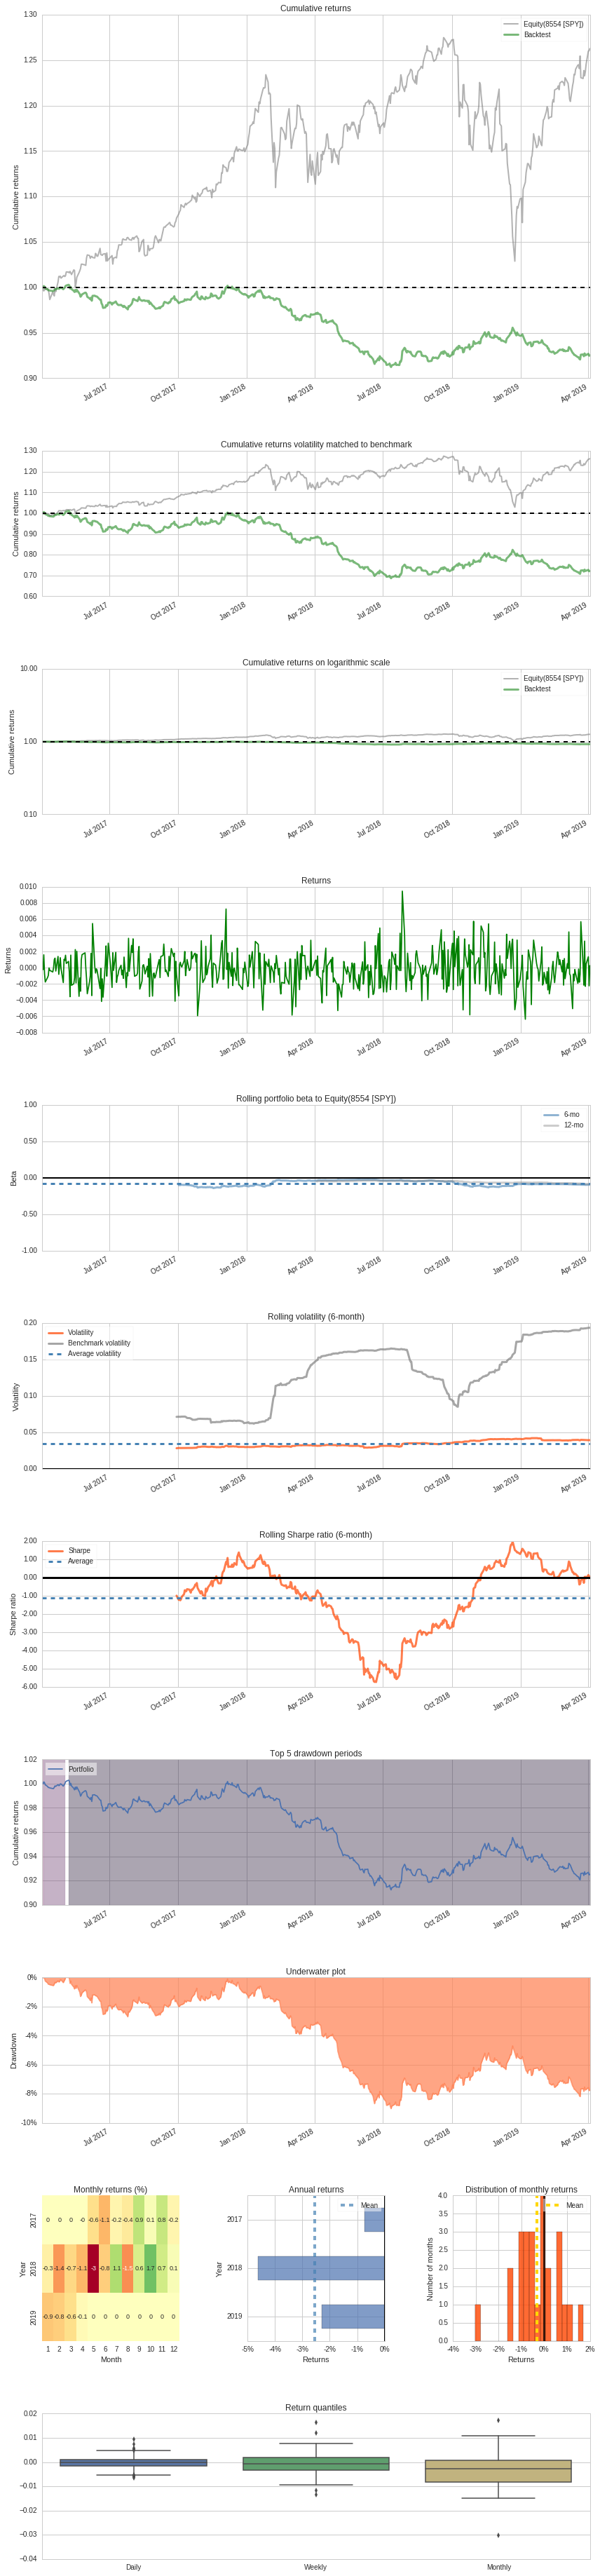

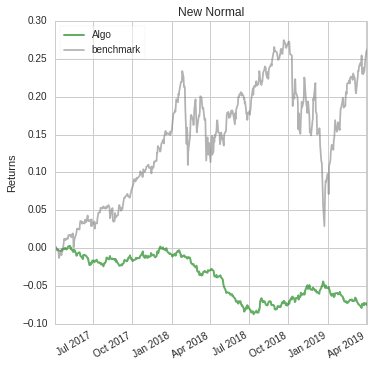

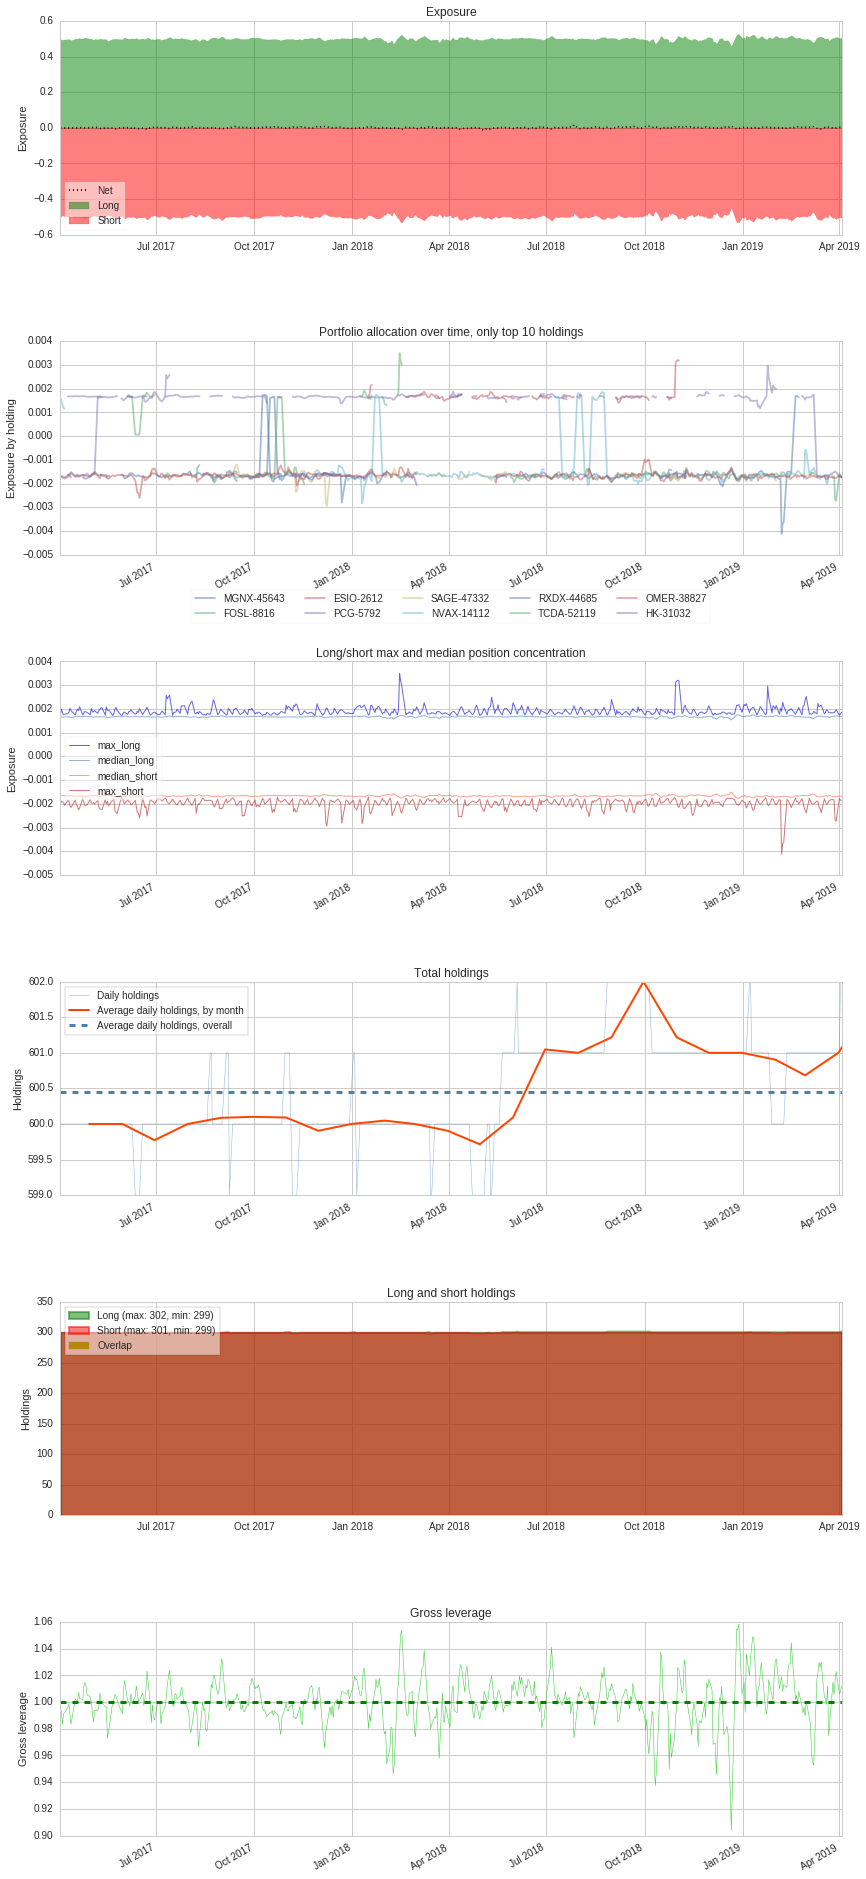

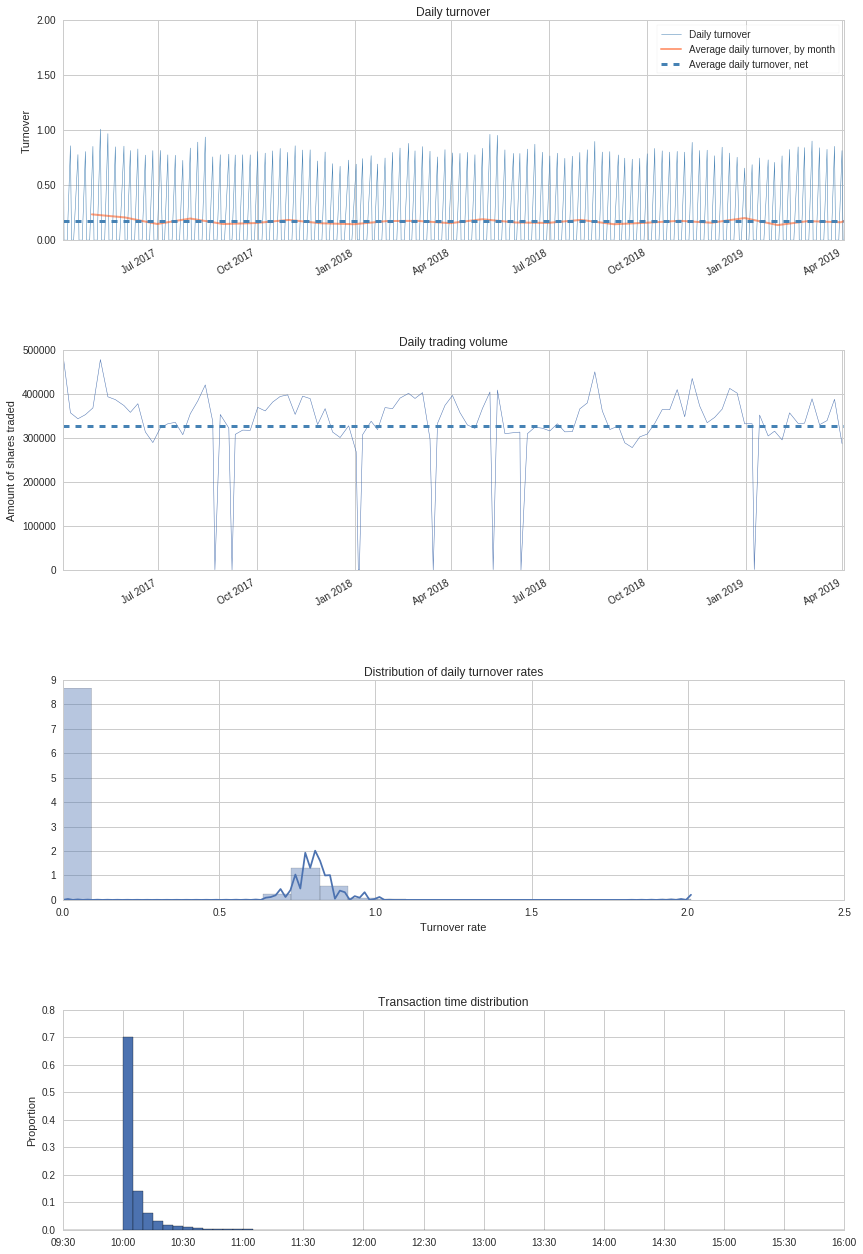

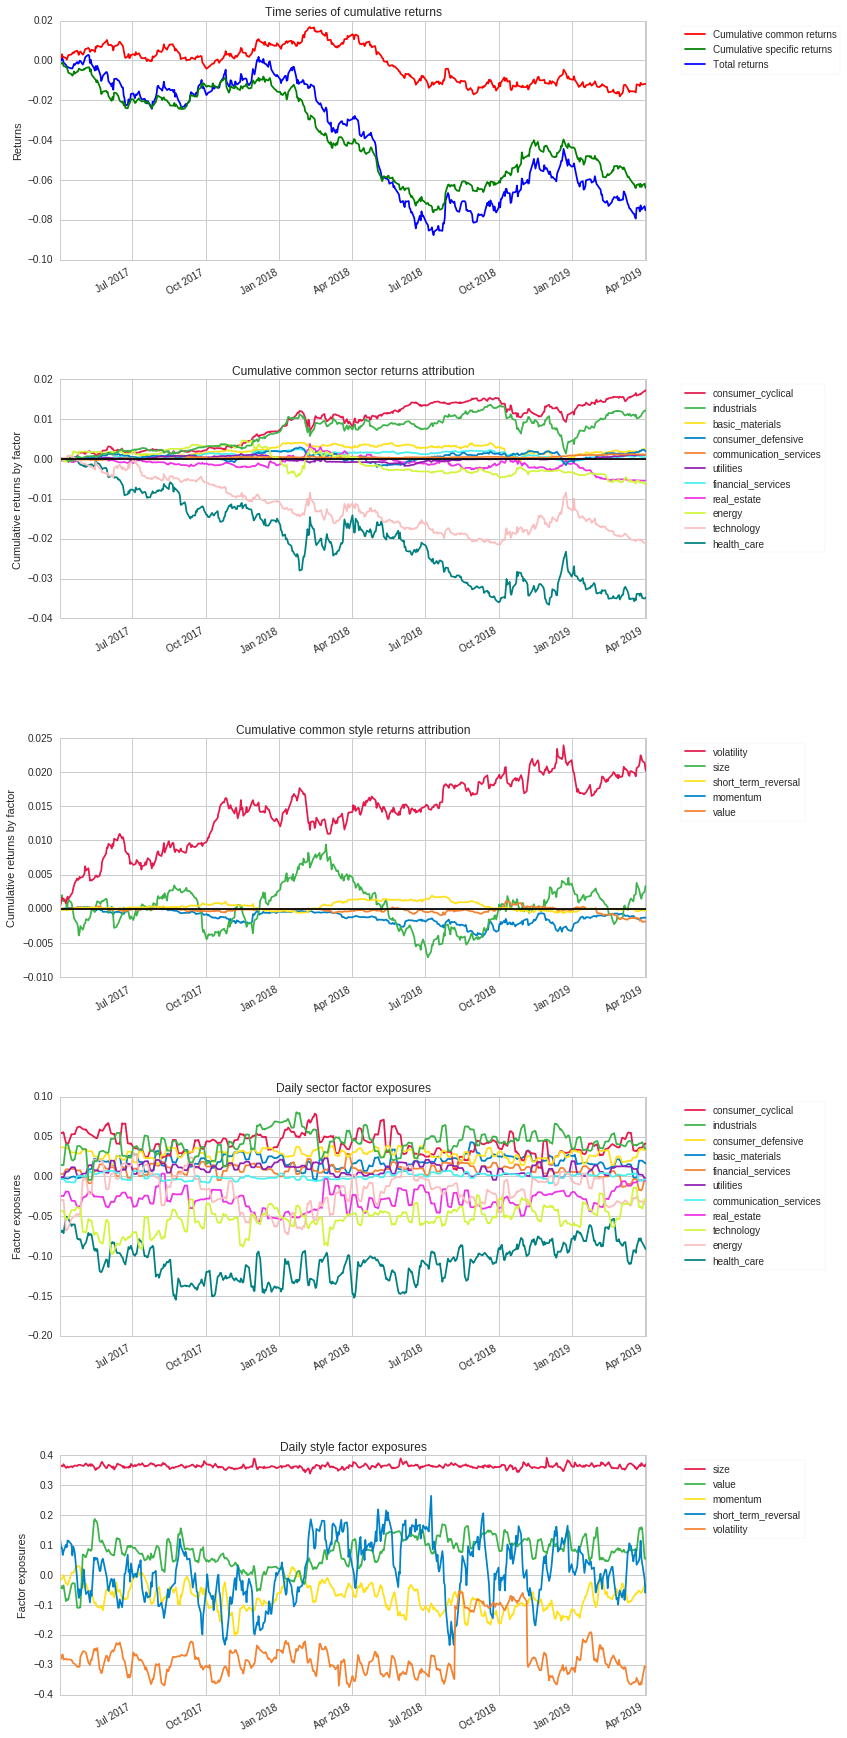

In [2]:
bt = get_backtest('5e8a79f0c02477458cfd4c78')
bt.create_full_tear_sheet()

##Six months before analisys

100% Time:  0:00:10|##########################################################|


Start date,2018-10-03
End date,2019-04-03
Total months,5
,Backtest
Annual return,-1.28%
Cumulative returns,-0.637%
Annual volatility,3.814%
Sharpe ratio,-0.32
Calmar ratio,-0.35
Stability,0.25
Max drawdown,-3.659%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,3.66,2018-12-21,2019-03-21,NaT,NaN
1,1.22,2018-11-19,2018-12-12,2018-12-20,24
2,0.76,2018-10-10,2018-10-16,2018-10-24,11
3,0.58,2018-10-24,2018-10-25,2018-10-30,5
4,0.50,2018-11-14,2018-11-16,2018-11-19,4


Stress Events,mean,min,max
New Normal,-0.00%,-0.64%,0.58%


Top 10 long positions of all time,max
ESIO-2612,0.32%
PCG-5792,0.30%
TGTX-13984,0.25%
EOLS-51743,0.23%
SFIX-51467,0.22%
CELG-1406,0.22%
ZIOP-31341,0.22%
PLUG-20776,0.22%
MDB-51314,0.22%
CROX-28078,0.22%


Top 10 short positions of all time,max
MGNX-45643,-0.41%
TCDA-52119,-0.27%
TAHO-39938,-0.25%
TNDM-45852,-0.24%
CVIA-52059,-0.24%
PBYI-42689,-0.23%
TSRO-43124,-0.23%
SNAP-50683,-0.23%
MRTX-45080,-0.23%
CHRS-48026,-0.22%


Top 10 positions of all time,max
MGNX-45643,0.41%
ESIO-2612,0.32%
PCG-5792,0.30%
TCDA-52119,0.27%
TGTX-13984,0.25%
TAHO-39938,0.25%
TNDM-45852,0.24%
CVIA-52059,0.24%
PBYI-42689,0.23%
TSRO-43124,0.23%


/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j
/venvs/py35/lib/python3.5/site-packages/pyfolio/perf_attrib.py:564: UserWarning: Could not determine risk exposures for some of this algorithm's positions. Returns from the missing assets will not be properly accounted for in performance attribution.

The following assets were missing factor loadings: ['DOW-52991'].. Ignoring for exposure calculation and performance attribution. Ratio of assets missing: 0.001. Average allocation of missing assets:

DOW-52991    5755.86
dtype: float64.

  warnings.warn(missing_stocks_warning_msg)


## Performance Relative to Common Risk Factors

Summary Statistics,
Annualized Specific Return,-1.00%
Annualized Common Return,-0.26%
Annualized Total Return,-1.28%
Specific Sharpe Ratio,-0.38


Exposures Summary,Average Risk Factor Exposure,Annualized Return,Cumulative Return
basic_materials,0.02,0.04%,0.02%
consumer_cyclical,0.03,0.71%,0.35%
financial_services,0.00,-0.26%,-0.13%
real_estate,-0.02,-0.98%,-0.49%
consumer_defensive,0.02,0.15%,0.07%
health_care,-0.08,0.02%,0.01%
utilities,0.01,0.19%,0.09%
communication_services,0.00,0.11%,0.05%
energy,-0.02,-0.23%,-0.12%
industrials,0.05,-0.21%,-0.11%


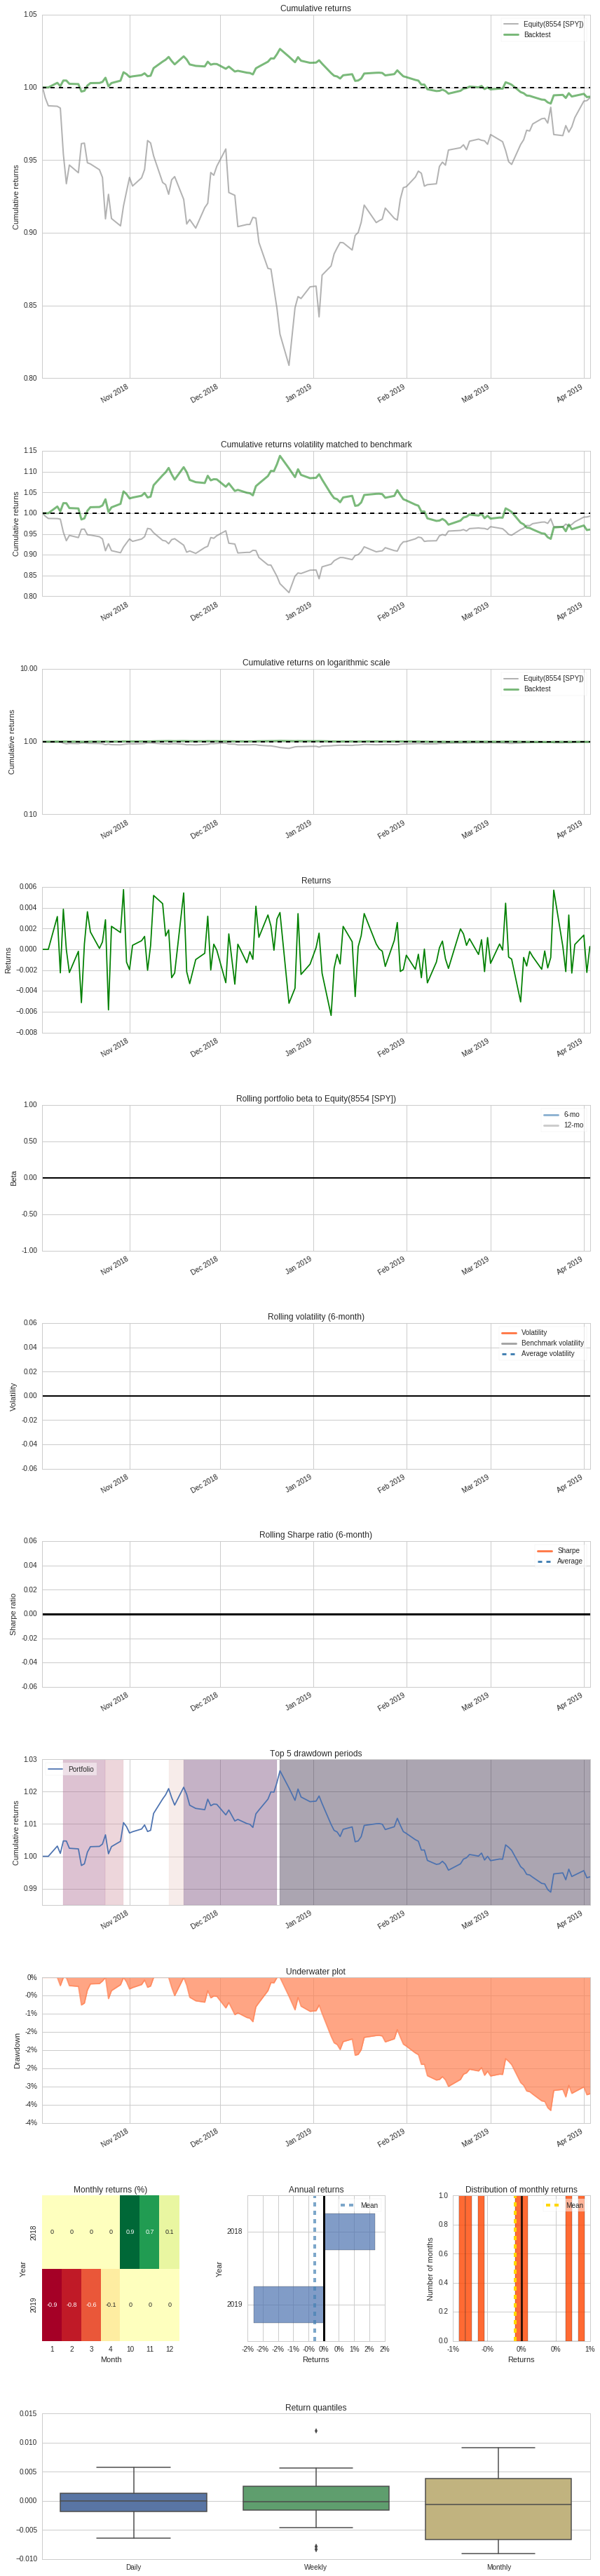

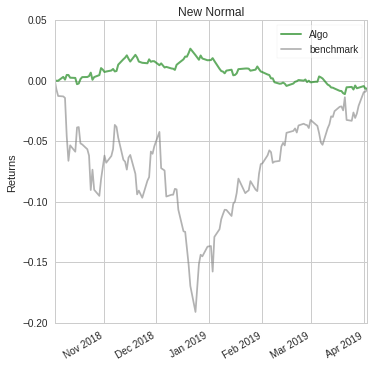

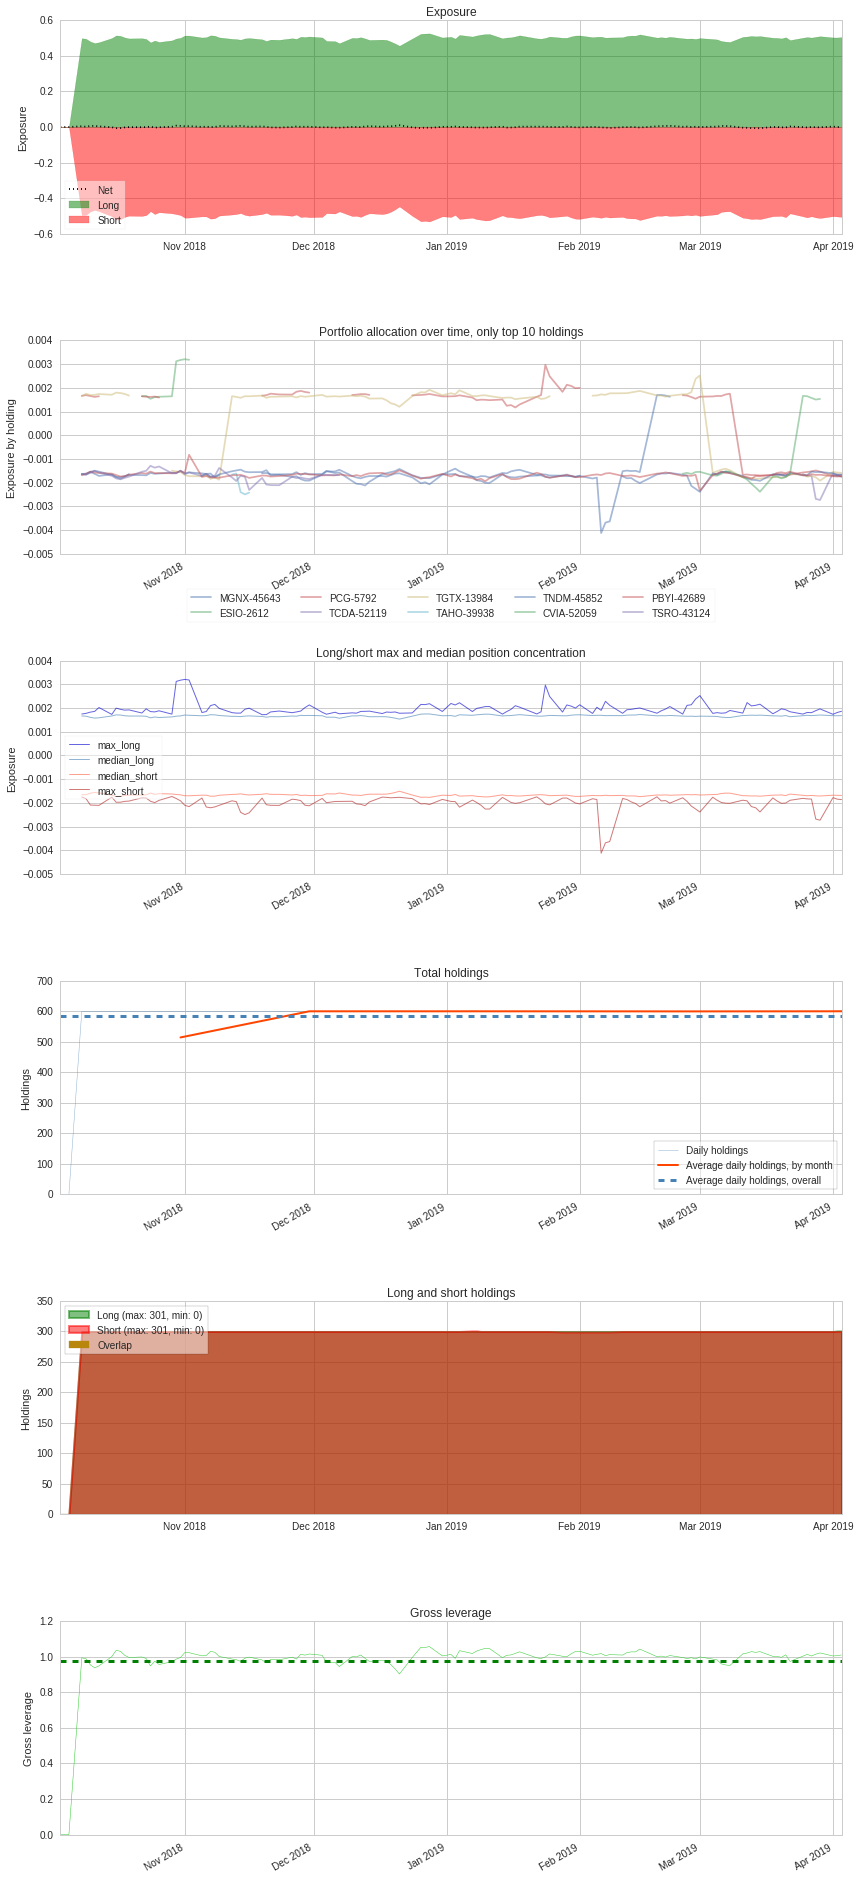

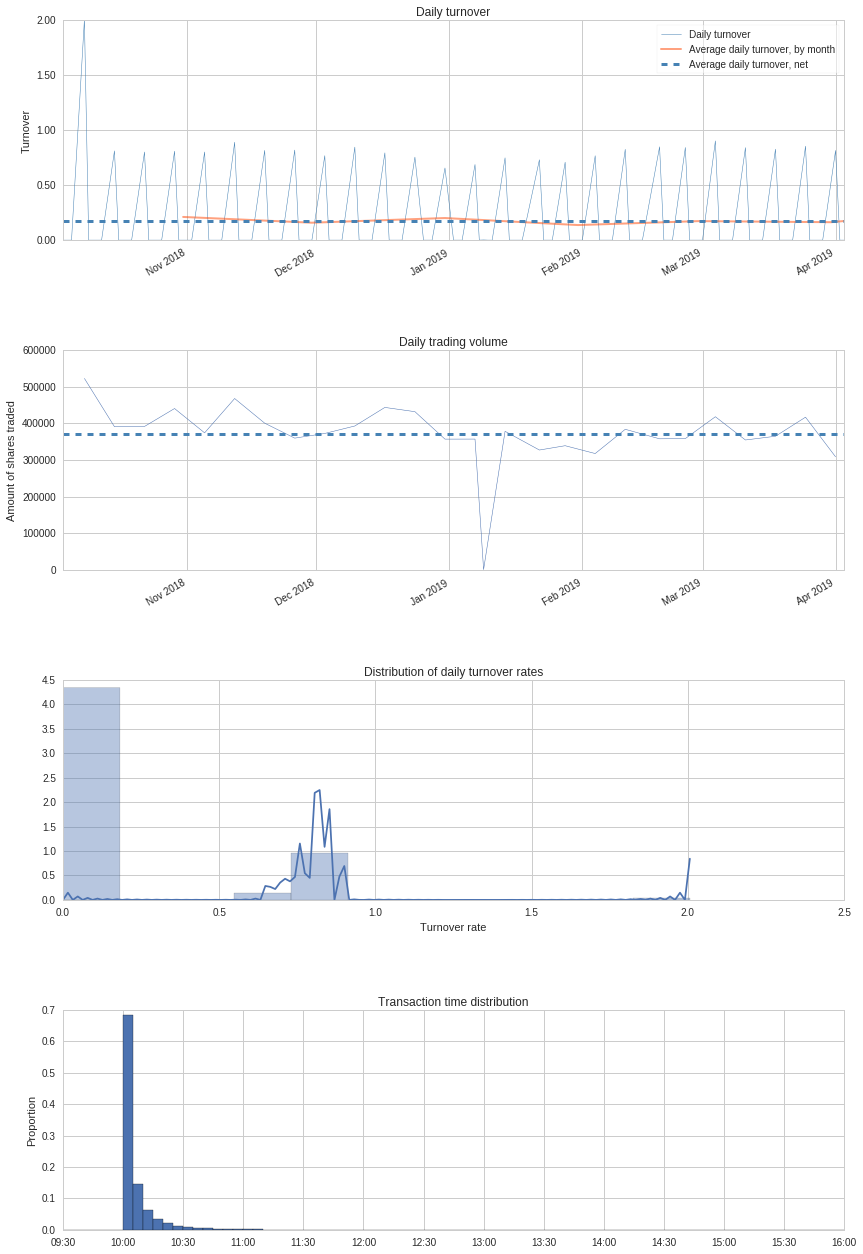

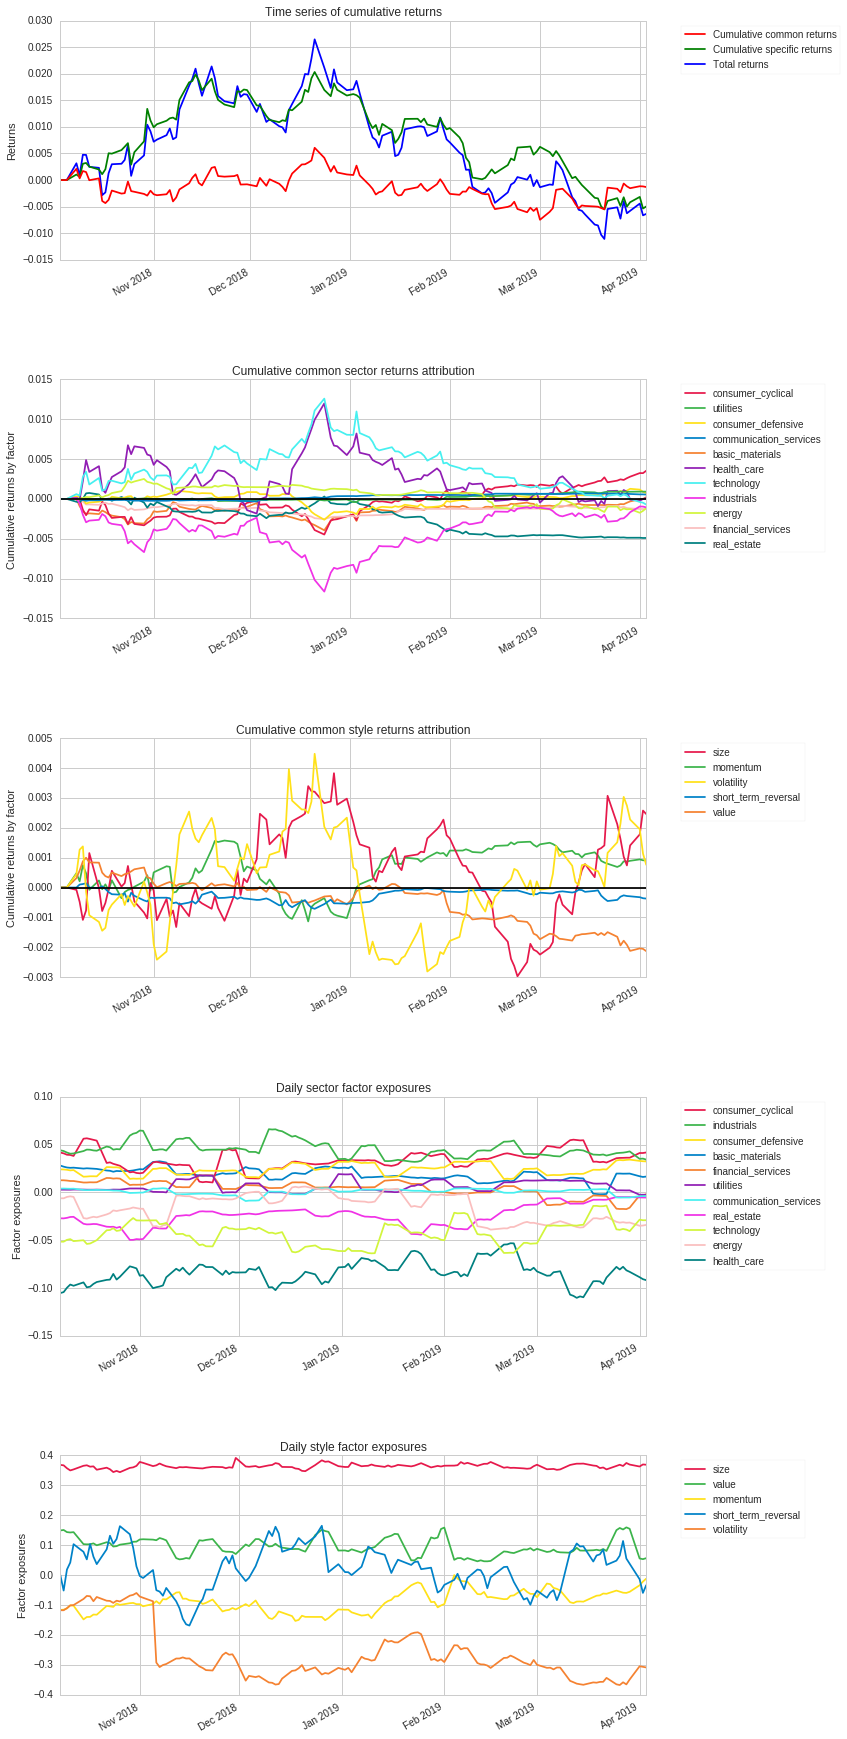

In [2]:
bt = get_backtest('5e8a7eea3f3c9e45b7c9b4c4')
bt.create_full_tear_sheet()